In [86]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Data Cleaning: Deduplication


In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#final=final.drop_duplicates(subset={"UserId","ProductId","Time"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [ ]:
Data-preprocessing

In [10]:
# find sentences containing HTML tags
import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"you'll", 'most', 'on', "doesn't", "she's", 'being', 'through', 'her', 'up', "it's", 'had', 'themselves', 'they', 'again', 'during', 'him', 'are', 'or', 'once', 'about', 'where', 'now', "isn't", 'shouldn', 'before', "that'll", 'any', "mustn't", 'is', 'their', 'you', 'its', 'very', 'hadn', 'this', 'an', 'of', 'has', 'mustn', 'so', 'm', 'than', "won't", "you've", 'my', 'and', 'no', "don't", 'below', 'out', 's', 'for', "mightn't", "shan't", "weren't", 'own', "should've", 'myself', 'have', 'these', 'too', 'other', 'ourselves', 'he', 'whom', 'down', 'shan', "you'd", 'into', 'that', 'having', "aren't", "didn't", 'was', 'further', 'not', "wouldn't", 't', 'haven', 'with', 'yourselves', 'to', 'it', 'because', 'both', 'who', 'what', 'should', 'more', 'itself', 'those', 'until', "hasn't", 'needn', 'against', "couldn't", 'such', 'but', 'only', 'will', 'here', 'd', 're', 'aren', 'wasn', 'nor', 'herself', 'i', 'same', 'them', 'some', "haven't", 'when', 'does', 'why', 'between', 'which', 'while', 'm

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [14]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [15]:
final_df = pd.DataFrame(final) # converting table to a dataframe

In [16]:
random_final = final_df.sample(n=10000) # Sampling 10k rows 
random_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
336622,364231,B000HZJRWK,A1ZLS80IXSLH84,"Patricia Hood ""pre school teacher""",0,0,positive,1304467200,Lotta taste in a little cube,I use these cubes in soups and a rice dish i m...,b'use cube soup rice dish make hard find thnx ...
116419,126251,B00100GO0Y,A1WR738IECEJBX,TactNot,0,0,negative,1286755200,Ass Kickin' Popcorn,"There are supposed to be 3 flavors (barbecue, ...",b'suppos flavor barbecu kettl corn habanero po...
487890,527577,B000QSON4K,A2PNDM8EM278GX,Ellen Peterson,4,4,negative,1247184000,I don't believe these were authentic Greenie's...,The Greenie's pill pockets I purchased through...,b'greeni pill pocket purchas amazon like bag i...
97928,106392,B0036B8B0Q,A2Y6WAHMYSIPJV,Lisa,2,2,positive,1269561600,Delicious....,These are so incredibly good. Love the new gr...,b'incred good love new grape flavor much bette...
179534,194742,B0030FGMZY,A24ZV048V7J0MT,"Murphy ""Goldenmom""",0,0,positive,1293408000,Great Health Treat,I have been giving my old golden retriever Hap...,b'give old golden retriev happi hip item year ...
138477,150284,B000LRH74O,A2V8YKMCP2GDVA,Mark Levy,0,0,positive,1333929600,Almond Paste,"Great product, albeit on the expensive side. W...",b'great product albeit expens side would proba...
337935,365645,B002VB832S,A11OJGXBY1HVNL,Cels' Deal,1,2,positive,1301875200,It Doesn't Have To Be Winter........,I am a hot chocolate snob. Ghirardelli at any ...,b'hot chocol snob ghirardelli price local groc...
323959,350644,B002OL2MWM,A3GJK3HASZPUSP,Bibi,0,0,positive,1306454400,best purchase ever!,I actually baught two of these. first one was ...,b'actual baught two first one gift got tri win...
477208,516053,B000DINEQG,AQI8X1T8JFOWR,Tina M. Morrison,0,0,positive,1208995200,Great Product,My bigger dog can get through one of these pre...,b'bigger dog get one pretti quick last lot lon...
41017,44571,B001EQ55RW,AY2W3IHAYU47Z,G. Swanson,0,0,positive,1269302400,Nuts abot these nuts!,I read the reviews and thought they sounded go...,b'read review thought sound good tri better ex...


In [17]:
random_final = random_final.sort_values('Time') # Sorting the dataframe based on Time

In [18]:
random_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...,b'book favorit mine sinc abl read one first in...
184396,200021,B0000D9N5Q,A176XYKMRF1U8Q,Lance Arthur,0,0,positive,1067990400,A small taste of heaven,Pierre Robert is similar to Brie but with a sm...,b'pierr robert similar brie smoother creamier ...
516067,557955,B0000DJDL4,A15SCA1C3F22KW,"Mom2two ""sdbartels2""",0,0,positive,1067990400,Great Holiday tradition,Our family has been giving and recieving Kring...,b'famili give reciev kringl mani year one dani...
266581,288965,B00016LYWQ,AIGOF5NFVOTZ7,"""tomshorearizona""",1,1,positive,1072310400,This is wonderful coffee!,I got this for Christmas and will be ordering ...,b'got christma order bag gone nice subtl aroma...
155351,168492,B0001ES9F8,A1BANTW2ZEGCI7,"""all4gizmo""",6,6,positive,1090022400,Awesome!!!,Just got my Senseo yesterday. It is the great...,b'got senseo yesterday greatest thing sinc sli...
158751,172117,B0001E3LAQ,A2STLT852H9K75,"Alex J. Avriette ""Alex Avriette""",11,11,positive,1091059200,"Very spicy, a little too sticky and moist",I received a very well packaged (and promptly ...,b'receiv well packag prompt ship even packag h...
141336,153378,B001ID8A28,A2W4BO3M0A1KPL,"KSL ""emma-and-me""",8,8,positive,1092614400,This book should be in your future!!!,This is a great book about fortune cookies and...,b'great book fortun cooki messag mei mei famil...
261575,283554,B0001BVFFC,ADCNNJ5770OSQ,H James Lucas,1,1,positive,1097712000,One of the finest cream sodas available,Boylan Bottleworks Creme is one of the finest ...,b'boylan bottlework creme one finest soda avai...
170290,184743,B0000V1DTG,AUXXFTG8U1FRG,Blondie,1,1,positive,1100476800,Fabulous!,This is the best chamomlie tea I've tasted! I...,b'best chamomli tea ive tast tea connoisseur r...


In [19]:
y_w2v = random_final['Score']
random_final.drop(['Score'], axis=1, inplace=True)
X_w2v = random_final

In [20]:
X_w2v.shape

(10000, 10)

In [21]:
from sklearn.model_selection import train_test_split

# split the data set into train and test in 70% train and 30% test
X3, X_test3, y3, y_test3 = train_test_split(X_w2v, y_w2v, test_size=0.3, shuffle=False, random_state=42)

In [ ]:
Average-Word2Vec

In [34]:
# Training Word2Vec using our corpus on Train data 
import gensim
i=0
list_of_sent=[]
for sent in X3['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [35]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=6) 

In [36]:
# Applying average word2vec on test data
import gensim
i=0
list_of_sent1=[]
for sent in X_test3['Text'].values:
    filtered_sentence1=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence1.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent1.append(filtered_sentence1)
    

In [37]:
w2v_model1=gensim.models.Word2Vec(list_of_sent1,min_count=5,size=50, workers=6)    


In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [39]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent1: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    cnt_words1 =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model1.wv[word]
            sent_vec1 += vec
            cnt_words1 += 1
        except:
            pass
    sent_vec1 /= cnt_words1
    sent_vectors1.append(sent_vec1)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

3000
50


In [40]:
df_w2v = pd.DataFrame(sent_vectors) # storing average w2vec in a dataframe 

In [41]:
df_w2v1 = pd.DataFrame(sent_vectors1)

In [42]:
df_w2v.isnull().any() # Check whether if there is any Nan value

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [43]:
df_w2v1.isnull().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [44]:
# Oversampling for Decision Tree
from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', random_state=42, kind='borderline1',  n_jobs=-1) # using the borderline1 algo for resampling on minority class
X5, y5 = sm.fit_sample(df_w2v, y3)

In [45]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v = StandardScaler().fit_transform(X5)
print(standardized_data_av_w2v.shape)

(11948, 50)


In [46]:
X_av_w2v_tr = np.array(standardized_data_av_w2v)

In [47]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v1 = StandardScaler().fit_transform(df_w2v1)
print(standardized_data_av_w2v1.shape)

(3000, 50)


In [48]:
X_av_w2v_te = np.array(standardized_data_av_w2v1)


The optimal depth is 14.


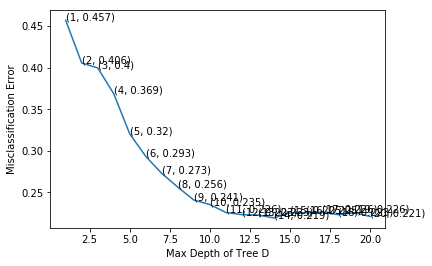

the misclassification error for each depth value is :  [0.457 0.406 0.4   0.369 0.32  0.293 0.273 0.256 0.241 0.235 0.226 0.223
 0.223 0.219 0.225 0.225 0.226 0.223 0.226 0.221]


In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
                            
    
# creating depth for Decision Tree
myDepth = list(range(1,21))

# empty list that will hold cv scores
cv_scores = []

tss_dc = TimeSeriesSplit(n_splits=10) # split the data using TimeSeriesSplit with number of splits=10

# perform 10-fold cross validation 
for d in myDepth:
    dtc = DecisionTreeClassifier(max_depth = d, random_state = 42, presort = True) # as the data is sampled and not large so pre-sorting it
    scores = cross_val_score(dtc, X_av_w2v_tr, y5, cv=tss_dc)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best depth
best_d = myDepth[MSE.index(min(MSE))]
print('\nThe optimal depth is %d.' % best_d)

# plot misclassification error vs depth 
plt.plot(myDepth, MSE)

for xy in zip(myDepth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Max Depth of Tree D')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MSE,3))


In [50]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score, precision_score


# instantiate learning model for best depth
dt_w2v_op = DecisionTreeClassifier(max_depth = 14, random_state = 42, presort = True)

# fitting the model
dt_w2v_op.fit(X_av_w2v_tr, y5)

# predict the response
pred_dt_w2v_op = dt_w2v_op.predict(X_av_w2v_te)

print()

# evaluate various performance measures:
print("Accuracy = ",accuracy_score(y_test3, pred_dt_w2v_op)) # accuracy
print("Confusion Matrix\n", confusion_matrix(y_test3, pred_dt_w2v_op)) # Confusion Matrix
tn, fn, fp, tp = confusion_matrix(y_test3, pred_dt_w2v_op).ravel() # tn, fn, fp, tp
print("(tn, fn, fp, tp) =",(tn, fn, fp, tp))
print("Recall = ",recall_score(y_test3, pred_dt_w2v_op, pos_label='positive')) # Recall
print("f1-Score = "  ,f1_score(y_test3, pred_dt_w2v_op, pos_label='positive')) # f1-Score
print("Precision = ",precision_score(y_test3, pred_dt_w2v_op, pos_label='positive'))# Precision



Accuracy =  0.627
Confusion Matrix
 [[ 243  244]
 [ 875 1638]]
(tn, fn, fp, tp) = (243, 244, 875, 1638)
Recall =  0.6518105849582173
f1-Score =  0.7453924914675768
Precision =  0.8703506907545164


In [ ]:
tfidf-w2v

In [51]:
from sklearn.model_selection import train_test_split

# split the data set into train and test in 70% train and 30% test
X4, X_test4, y4, y_test4 = train_test_split(X_w2v, y_w2v, test_size=0.3, shuffle=False, random_state=42)

In [52]:
# Taking Tf-idf unigram and vectorizing it
tf_idf_vect = TfidfVectorizer()
X_tf = tf_idf_vect.fit_transform(X4['CleanedText'].values)
y_tf = tf_idf_vect.fit_transform(X_test4['CleanedText'].values)

In [53]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

/home/shebu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


7000
50


In [54]:
df_w2v_tf = pd.DataFrame(tfidf_sent_vectors) # storing average w2vec in a dataframe 

In [55]:
df_w2v_tf.isnull().any() # Check whether if there is any Nan value

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
dtype: bool

In [56]:
df_w2v_tf = df_w2v_tf.fillna(0) #filling the dataframe with 0 if there is any Nan entry

In [63]:
# Oversampling of train data in order to make the minority class balanced with majority class

from imblearn.over_sampling import SMOTE

sm = SMOTE(ratio='auto', random_state=42, kind='borderline1',  n_jobs=-1) # using the borderline1 algo for resampling on minority class
X6, y6 = sm.fit_sample(df_w2v_tf, y4)

In [65]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v_tf_tr = StandardScaler().fit_transform(X6)
print(standardized_data_av_w2v_tf_tr.shape)

(7000, 50)


In [68]:
X_w2v_tf_tr = np.array(standardized_data_av_w2v_tf_tr)

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent1: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec1 += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec1 /= weight_sum
    tfidf_sent_vectors1.append(sent_vec1)
    row += 1
    
print(len(tfidf_sent_vectors1))
print(len(tfidf_sent_vectors1[0]))

/home/shebu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


3000
50


In [60]:
df_w2v_tf_1 = pd.DataFrame(tfidf_sent_vectors1) # storing average w2vec in a dataframe 

In [66]:
df_w2v_tf_1 = df_w2v_tf_1.fillna(0) #filling the dataframe with 0 if there is any Nan entry

In [67]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v_tf_te = StandardScaler().fit_transform(df_w2v_tf_1)
print(standardized_data_av_w2v_tf_te.shape)

(3000, 50)


In [69]:
X_w2v_tf_te = np.array(standardized_data_av_w2v_tf_te)


The optimal depth is 1.


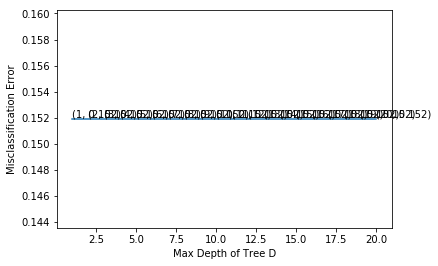

the misclassification error for each depth value is :  [0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.152]


In [70]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
                            
    
# creating depth for Decision Tree
myDepth_tf = list(range(1,21))

# empty list that will hold cv scores
cv_scores_t = []

tss_d_tf = TimeSeriesSplit(n_splits=10) # split the data using TimeSeriesSplit with number of splits=10

# perform 10-fold cross validation 
for d in myDepth_tf:
    dtc_tf = DecisionTreeClassifier(max_depth = d, random_state = 0, presort = True) # as the data is sampled and not large so pre-sorting it
    scores_t = cross_val_score(dtc_tf, X_w2v_tf_tr, y6, cv=tss_d_tf)
    cv_scores_t.append(scores_t.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores_t]

# determining best depth
best_dtf = myDepth_tf[MSE.index(min(MSE))]
print('\nThe optimal depth is %d.' % best_dtf)

# plot misclassification error vs depth 
plt.plot(myDepth_tf, MSE)

for xy in zip(myDepth_tf, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Max Depth of Tree D')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth value is : ", np.round(MSE,3))


In [84]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score, precision_score


# instantiate learning model for best depth
dt_w2v_op_tf = DecisionTreeClassifier(max_depth = 1, random_state = 42, presort = True)

# fitting the model
dt_w2v_op_tf.fit(X_w2v_tf_tr, y6)

# predict the response
pred_dt_w2v_op_tf = dt_w2v_op_tf.predict(X_w2v_tf_te)

print()

# evaluate various performance measures:
print("Accuracy = ",accuracy_score(y_test4, pred_dt_w2v_op_tf)) # accuracy
print("Confusion Matrix\n", confusion_matrix(y_test4, pred_dt_w2v_op_tf)) # Confusion Matrix
tn, fn, fp, tp = confusion_matrix(y_test4, pred_dt_w2v_op_tf).ravel() # tn, fn, fp, tp
print("(tn, fn, fp, tp) =",(tn, fn, fp, tp))
print("Recall = ",recall_score(y_test4, pred_dt_w2v_op_tf, pos_label='positive')) # Recall
print("f1-Score = "  ,f1_score(y_test4, pred_dt_w2v_op_tf, pos_label='positive')) # f1-Score
print("Precision = ",precision_score(y_test4, pred_dt_w2v_op_tf, pos_label='positive'))# Precision



Accuracy =  0.8376666666666667
Confusion Matrix
 [[   0  487]
 [   0 2513]]
(tn, fn, fp, tp) = (0, 487, 0, 2513)
Recall =  1.0
f1-Score =  0.9116633411935425
Precision =  0.8376666666666667


In [85]:
from tabulate import tabulate
import operator
import collections
import itertools

table = []

bold = "\033[1m"
reset = "\033[0;0m"

print()
print(bold+"F1-Score using Av.Word2Vec and Tfidf-w2v"+reset)
table.append([bold+"Average-word2vec"+reset, 14, 0.7453, (0.219*100)])
table.append([bold+"Tfidf-w2v"+reset, 1, 0.9116, (0.152*100)])
print(tabulate(table, headers=[bold+'Best-Hyperparam(max_depth)','F1-Score','Missclassified(%)'+reset], tablefmt='grid'))
print("-----------------------------------------------")
table.clear()


F1-Score using Av.Word2Vec and Tfidf-w2v
+------------------+------------------------------+------------+---------------------+
|                  |   Best-Hyperparam(max_depth) |   F1-Score |   Missclassified(%) |
+==================+==============================+============+=====================+
| Average-word2vec |                           14 |     0.7453 |                21.9 |
+------------------+------------------------------+------------+---------------------+
| Tfidf-w2v        |                            1 |     0.9116 |                15.2 |
+------------------+------------------------------+------------+---------------------+
-----------------------------------------------
